In [37]:
import pandas as pd
from mne import create_info
from mne.io import RawArray
import  mne
import numpy as np

df = pd.read_csv('ssvep-10trials-3s-chaky-bigsquare.csv')
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)
df.head()

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


In [38]:
def df_to_raw(df):
    sfreq = 250
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw

Creating RawArray with float64 data, n_channels=4, n_times=32952
    Range : 0 ... 32951 =      0.000 ...   131.804 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 77 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 77.00 Hz: -6.02, -6.02 dB


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


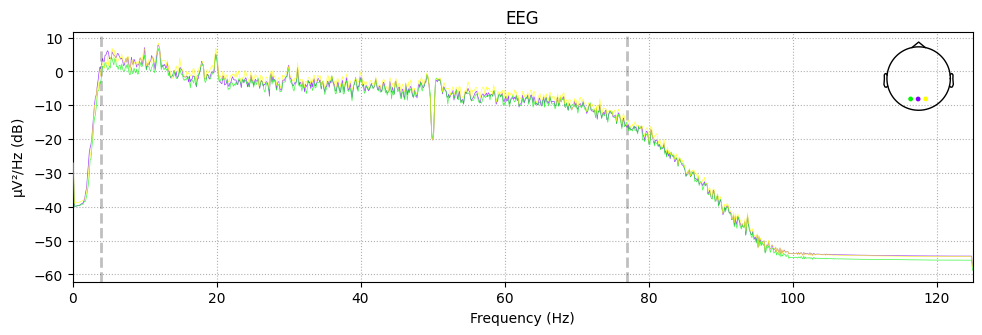

In [39]:
raw = df_to_raw(df)
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.filter(4, 77, method='iir')

raw.plot_psd()

In [40]:
events = mne.find_events(raw)
# event_id = {
#     '6hz': 1,
#     '10hz': 2
# }
# epochs = mne.Epochs(raw=raw_new,events=events, baseline=None, tmin=0.14, tmax=0.64 - 1/250, reject=None, reject_by_annotation=False)
epochs = mne.Epochs(raw=raw, events=events, baseline=None, tmin=1.5, tmax=3.5, reject=None, reject_by_annotation=False)

# epochs = mne.Epochs(raw=raw,event_id=[event_id['6hz'], event_id['10hz']],events=events, baseline=None, tmin=0.5, tmax=3 - 1/250, reject=None, reject_by_annotation=False)
data = epochs.get_data() 
print(data.shape)

30 events found
Event IDs: [1 2 3]
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 501 original time points ...
0 bad epochs dropped
(30, 4, 501)


In [41]:
X = epochs.get_data()[:, :-1, :] * 1e-6  # micro-volt default
y = epochs.events[:, -1]

Using data from preloaded Raw for 30 events and 501 original time points ...


In [42]:
print(X.shape)
print(y.shape)

(30, 3, 501)
(30,)


In [43]:
y

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3], dtype=int64)

In [44]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    # P = abs(P @ P.T)
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

In [45]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
estimator=TRCA(n_components = 1, n_jobs=-1)
model = estimator.fit(X_train, y_train)
preds = model.predict(X_test)
acc = np.mean(preds == y_test)
print(preds)
print(y_test)
print(acc)

[3 3 1 2 1 2 1 1 2]
[3 2 2 2 2 1 1 3 2]
0.4444444444444444


In [46]:
from sklearn.model_selection import StratifiedKFold

estimator=TRCA(n_components = 1, n_jobs=-1)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)
accs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: ", y[train_index])
    print(f"  Test: ", y[test_index])
    model = estimator.fit(X[train_index], y[train_index])
    preds = model.predict(X[test_index])
    acc = np.mean(preds == y[test_index])
    accs.append(acc)
    print(y[test_index])
    print(preds)
    print(acc)
print("Average accuracy ==>", np.mean(accs))


StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Fold 0:
  Train:  [1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
  Test:  [1 2 3 1 2 3]
[1 2 3 1 2 3]
[2 1 2 1 2 3]
0.5
Fold 1:
  Train:  [1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
  Test:  [1 2 3 1 2 3]
[1 2 3 1 2 3]
[3 3 1 1 2 3]
0.5
Fold 2:
  Train:  [1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
  Test:  [1 2 3 1 2 3]
[1 2 3 1 2 3]
[2 1 2 2 2 2]
0.16666666666666666
Fold 3:
  Train:  [1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
  Test:  [1 2 3 1 2 3]
[1 2 3 1 2 3]
[2 2 1 2 2 1]
0.3333333333333333
Fold 4:
  Train:  [1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
  Test:  [1 2 3 1 2 3]
[1 2 3 1 2 3]
[3 1 1 1 3 3]
0.3333333333333333
Average accuracy ==> 0.36666666666666664


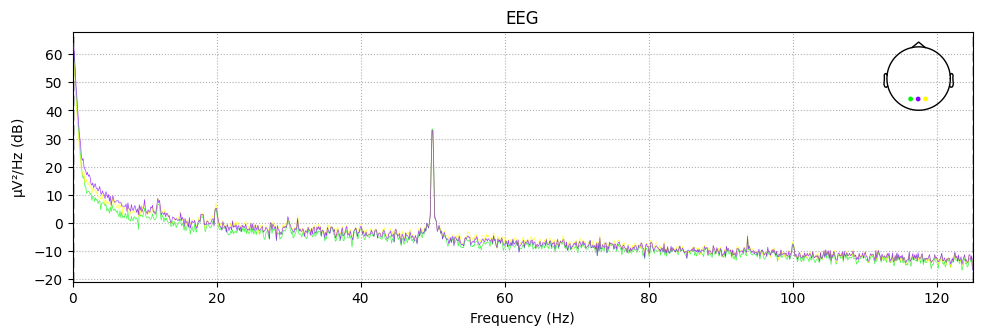

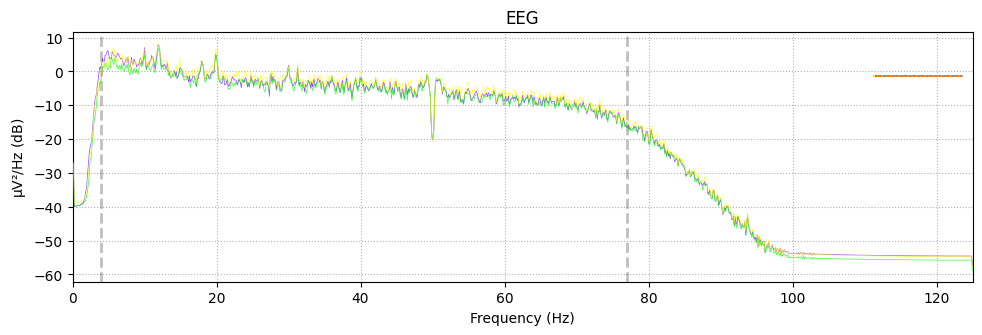

In [47]:
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(0, 1 + 1/100, 1/100)
a = np.sin(2 * np.pi * t * 10)
b = np.sin(2 * np.pi * (t+(2/100)) * 10)
# b = a * -1
plt.plot(a)
plt.plot(b)
plt.show()





In [48]:
np.corrcoef(a,b)

np.cov(a,b)

array([[0.5       , 0.1545085 ],
       [0.1545085 , 0.50895553]])